# **Ujian Akhir Semester - Pengolahan Bahasa Alami**

## Anggota Kelompok:
- **Kevin Philips Tanamas** (220711789)  
- **Richard Angelico** (220711747)
- **Anthony Alvin Nathaniel** (220711773)
- **Nicholas Raymond Thosimaru** (220712111)
- **Maria** (220711969)

## Library Import

In [126]:
import os
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

import gc
import fasttext
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from tensorflow.keras.layers import Conv1D

from sklearn.metrics import confusion_matrix
from seqeval.scheme import BILOU
from seqeval.metrics import classification_report, f1_score

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, GRU, Dense, TimeDistributed, Dropout
from collections import Counter
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, TimeDistributed, Dropout
from tensorflow.keras.layers import Masking
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

tqdm.pandas()

## Load Data

In [127]:
def insert_blank_lines(input_path, output_path):
    with open(input_path, 'r', encoding='utf-8') as infile, open(output_path, 'w', encoding='utf-8') as outfile:
        for line in infile:
            outfile.write(line)
            if line.strip().endswith(('.-O', '!-O', '?-O')):
                outfile.write('\n') 

insert_blank_lines("dataset_betawi.txt", "dataset_betawi_split.txt")

In [128]:
def load_data(file_path):
    sentences = []
    labels = []
    sentence = []
    label_seq = []

    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                # Baris kosong = akhir kalimat
                if sentence:
                    sentences.append(sentence)
                    labels.append(label_seq)
                    sentence = []
                    label_seq = []
                continue

            # Hapus nomor dan titik dua di depan (contoh: "12: Ane-O")
            if ":" in line:
                line = line.split(":", 1)[1].strip()

            if "-" not in line:
                continue

            token, tag = line.rsplit("-", 1)
            sentence.append(token)
            label_seq.append(tag)

        # Tambahkan kalimat terakhir jika ada
        if sentence:
            sentences.append(sentence)
            labels.append(label_seq)

    return sentences, labels

In [129]:
with open("./dataset_betawi_split.txt", "r", encoding="utf-8") as f:
    lines = f.readlines()

for i, line in enumerate(lines[:20]):
    print(f"{i+1}: {line.strip()}")


1: Ane-O
2: pake-O
3: Honda-B-PRODUCT
4: Jazz-I-PRODUCT
5: GK5-I-PRODUCT
6: 2014-L-PRODUCT
7: (-O
8: pertama-O
9: diluncurkan-O
10: )-O
11: .-O
12: 
13: Mobilnya-B-OTHERS_POSITIVE
14: bagus-I-OTHERS_POSITIVE
15: dan-I-OTHERS_POSITIVE
16: bagus-I-OTHERS_POSITIVE
17: sesuai-I-OTHERS_POSITIVE
18: motto-I-OTHERS_POSITIVE
19: ,-I-OTHERS_POSITIVE
20: asik-I-OTHERS_POSITIVE


In [130]:
# Load all data
full_file = "./dataset_betawi_split.txt"
sentences, labels = load_data(full_file)

# Check if data loaded
print(f"Loaded {len(sentences)} samples.")

# Split into train (70%) and temp (30%)
train_sentences, temp_sentences, train_labels, temp_labels = train_test_split(
    sentences, labels, test_size=0.3, random_state=42
)

# Split temp into validation (15%) and test (15%)
valid_sentences, test_sentences, valid_labels, test_labels = train_test_split(
    temp_sentences, temp_labels, test_size=0.5, random_state=42
)

# Create dataframes
train_df = pd.DataFrame({'tokens': train_sentences, 'tags': train_labels})
valid_df = pd.DataFrame({'tokens': valid_sentences, 'tags': valid_labels})
test_df = pd.DataFrame({'tokens': test_sentences, 'tags': test_labels})
df_all = pd.DataFrame({'tokens': sentences, 'tags': labels})

# Informasi tentang kolom
print("\nInformasi kolom DataFrame:")
print(df_all.dtypes)

# Deskripsi singkat isi data
lengths = [len(s) for s in sentences]
print("\nDeskripsi data:")
print(f"Total kalimat: {len(sentences)}")
print(f"Rata-rata panjang kalimat: {sum(lengths)/len(lengths):.2f} tokens")
print(f"Kalimat terpendek: {min(lengths)} tokens")
print(f"Kalimat terpanjang: {max(lengths)} tokens")

# Print sizes
print(f"Train: {len(train_df)}, Valid: {len(valid_df)}, Test: {len(test_df)}")

Loaded 867 samples.

Informasi kolom DataFrame:
tokens    object
tags      object
dtype: object

Deskripsi data:
Total kalimat: 867
Rata-rata panjang kalimat: 18.45 tokens
Kalimat terpendek: 1 tokens
Kalimat terpanjang: 124 tokens
Train: 606, Valid: 130, Test: 131


In [131]:
def validate_data(sentences, labels):
    for i, (sent, lbls) in enumerate(zip(sentences, labels)):
        if len(sent) != len(lbls):
            print(f"Mismatch in sentence {i}: {len(sent)} tokens, {len(lbls)} tags")
        for tag in lbls:
            if tag != 'O' and '-' not in tag:
                print(f"Invalid tag in sentence {i}: {tag}")
            if tag != 'O' and not any(prefix in tag for prefix in ['B-', 'I-', 'L-', 'U-']):
                print(f"Non-BILOU tag in sentence {i}: {tag}")

# Validate dataset after loading
print("Validating dataset...")
validate_data(sentences, labels)
print("Validation complete.")

Validating dataset...
Invalid tag in sentence 0: PRODUCT
Non-BILOU tag in sentence 0: PRODUCT
Invalid tag in sentence 0: PRODUCT
Non-BILOU tag in sentence 0: PRODUCT
Invalid tag in sentence 0: PRODUCT
Non-BILOU tag in sentence 0: PRODUCT
Invalid tag in sentence 0: PRODUCT
Non-BILOU tag in sentence 0: PRODUCT
Invalid tag in sentence 1: OTHERS_POSITIVE
Non-BILOU tag in sentence 1: OTHERS_POSITIVE
Invalid tag in sentence 1: OTHERS_POSITIVE
Non-BILOU tag in sentence 1: OTHERS_POSITIVE
Invalid tag in sentence 1: OTHERS_POSITIVE
Non-BILOU tag in sentence 1: OTHERS_POSITIVE
Invalid tag in sentence 1: OTHERS_POSITIVE
Non-BILOU tag in sentence 1: OTHERS_POSITIVE
Invalid tag in sentence 1: OTHERS_POSITIVE
Non-BILOU tag in sentence 1: OTHERS_POSITIVE
Invalid tag in sentence 1: OTHERS_POSITIVE
Non-BILOU tag in sentence 1: OTHERS_POSITIVE
Invalid tag in sentence 1: OTHERS_POSITIVE
Non-BILOU tag in sentence 1: OTHERS_POSITIVE
Invalid tag in sentence 1: OTHERS_POSITIVE
Non-BILOU tag in sentence 1: OT

## Data Checking (Liat Semua Tags) & Visualization

In [132]:
# Set all tags (flattened) from training labels
all_tags_flat = [tag for seq in train_labels for tag in seq]

print(f"Total tags in training: {len(all_tags_flat)}")

print("Tag distribution in training set:")
tag_counts = pd.Series(all_tags_flat).value_counts()
print(tag_counts.head(10))

Total tags in training: 11221
Tag distribution in training set:
O                   6845
PRODUCT             1093
OTHERS_POSITIVE      697
MACHINE_POSITIVE     471
PART_POSITIVE        441
PART_NEGATIVE        310
FUEL_POSITIVE        306
PRICE_POSITIVE       227
SERVICE_POSITIVE     214
SERVICE_NEGATIVE     193
Name: count, dtype: int64


/tmp/ipykernel_2181985/2071062896.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tag_counts.values, y=tag_counts.index, palette="viridis")


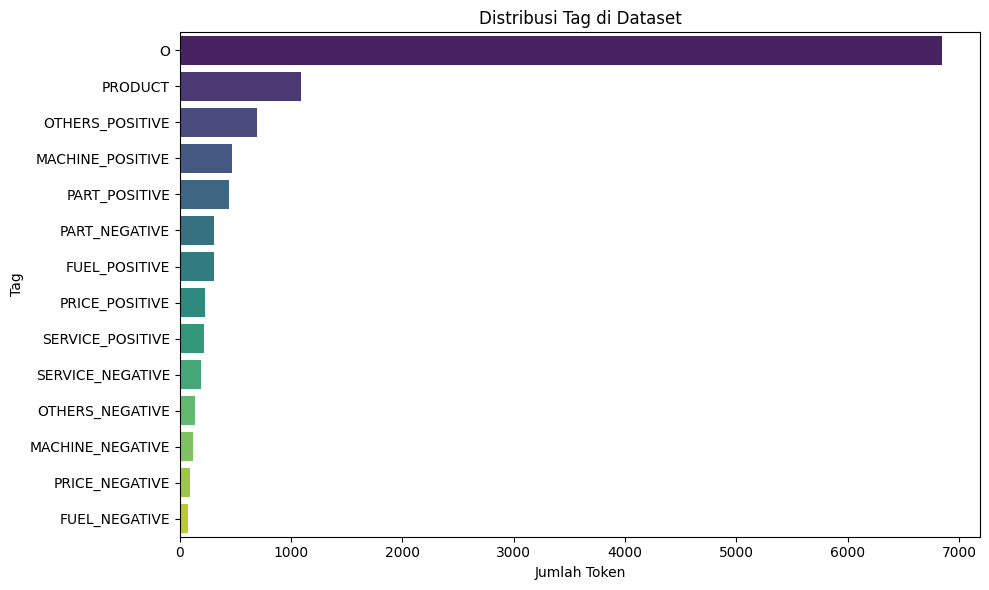

In [133]:
plt.figure(figsize=(10, 6))
sns.barplot(x=tag_counts.values, y=tag_counts.index, palette="viridis")
plt.title("Distribusi Tag di Dataset")
plt.xlabel("Jumlah Token")
plt.ylabel("Tag")
plt.tight_layout()
plt.show()

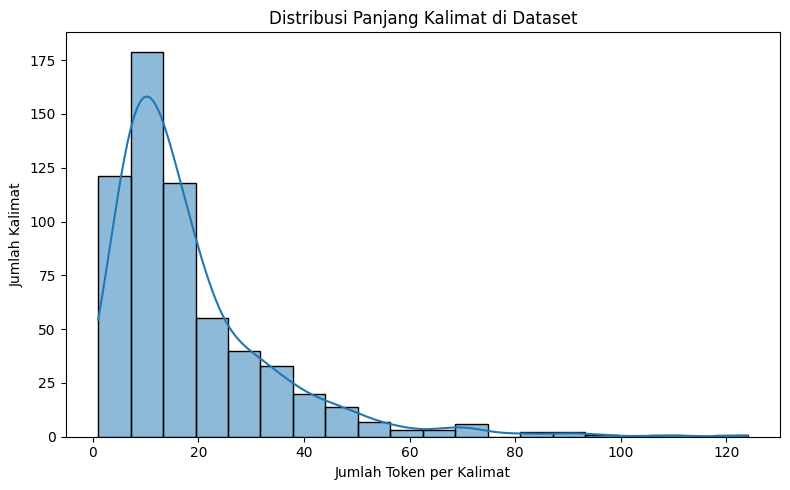

In [134]:
train_lengths = [len(seq) for seq in train_sentences]

plt.figure(figsize=(8, 5))
sns.histplot(train_lengths, bins=20, kde=True)
plt.title("Distribusi Panjang Kalimat di Dataset")
plt.xlabel("Jumlah Token per Kalimat")
plt.ylabel("Jumlah Kalimat")
plt.tight_layout()
plt.show()

/tmp/ipykernel_2181985/2212785168.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=common_tokens.values, y=common_tokens.index, palette="mako")


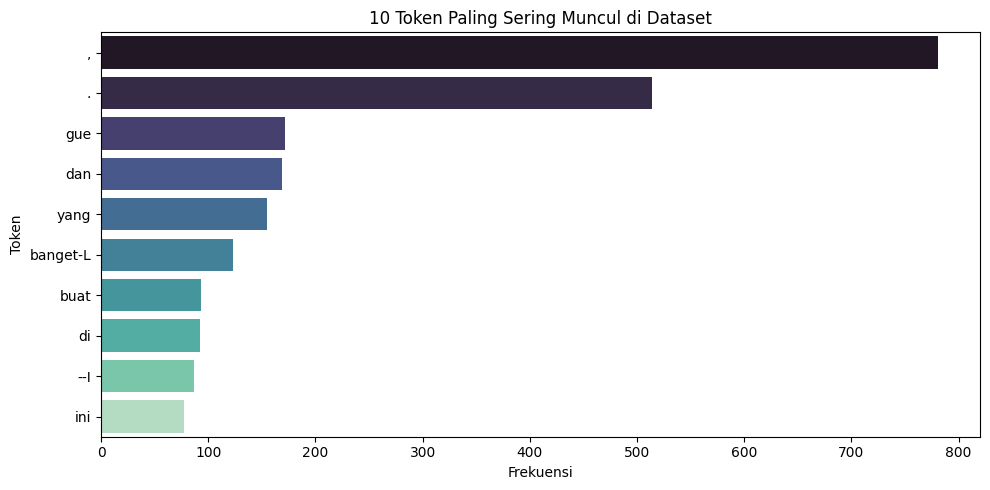

In [135]:
all_tokens = [tok for seq in train_sentences for tok in seq]
token_counts = Counter(all_tokens)
common_tokens = pd.Series(dict(token_counts.most_common(10)))

plt.figure(figsize=(10, 5))
sns.barplot(x=common_tokens.values, y=common_tokens.index, palette="mako")
plt.title("10 Token Paling Sering Muncul di Dataset")
plt.xlabel("Frekuensi")
plt.ylabel("Token")
plt.tight_layout()
plt.show()


/tmp/ipykernel_2181985/1962913272.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=split_counts.index, y=split_counts.values, palette="deep")


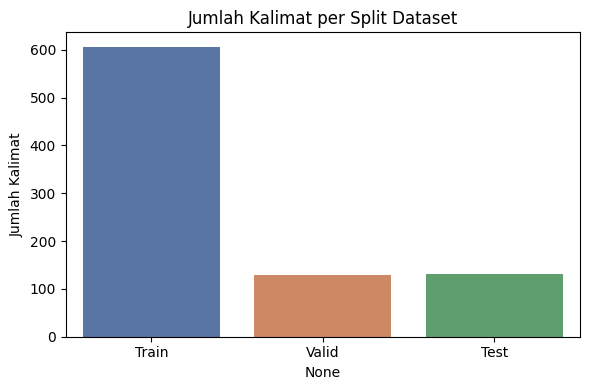

In [136]:
split_counts = pd.Series({
    "Train": len(train_df),
    "Valid": len(valid_df),
    "Test": len(test_df)
})

plt.figure(figsize=(6, 4))
sns.barplot(x=split_counts.index, y=split_counts.values, palette="deep")
plt.title("Jumlah Kalimat per Split Dataset")
plt.ylabel("Jumlah Kalimat")
plt.tight_layout()
plt.show()

## Load FastText Model

In [137]:
# Cek dan unduh FastText model jika belum tersedia
if not os.path.exists('./cc.id.300.bin'):
    print("FastText model not found. Downloading model (this may take a while)...")
    os.system("wget -c https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.bin.gz")
    os.system("gunzip cc.id.300.bin.gz")
    print("Download complete.")

# Load FastText model
# Download file .bin https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.bin.gz
# Extract file .gz
# Pastikan file cc.id.300.bin ada di direktori yang sama dengan Jupyter Notebook ini
print("Loading FastText model...")
ft = fasttext.load_model('./cc.id.300.bin')
print("FastText model loaded successfully.")

# Set embedding size dan panjang maksimum urutan
emb_size = 300
max_seq_len = 128


Loading FastText model...
FastText model loaded successfully.


## Tag Mapping

In [138]:
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Buat mapping tag ke ID
all_tags = sorted(set(tag for seq in train_df['tags'] for tag in seq))
tag2index = {tag: idx + 1 for idx, tag in enumerate(all_tags)}
tag2index['PAD'] = 0
index2tag = {idx: tag for tag, idx in tag2index.items()}

num_tags = len(tag2index)

# Fungsi untuk encoding dan padding label
def encode_tags(tags, tag2index, max_len):
    tag_ids = [tag2index.get(tag, tag2index['PAD']) for tag in tags]
    return pad_sequences([tag_ids], maxlen=max_len, padding='post', value=tag2index['PAD'])[0]

train_df['tag_ids'] = train_df['tags'].apply(lambda tags: encode_tags(tags, tag2index, max_seq_len))
valid_df['tag_ids'] = valid_df['tags'].apply(lambda tags: encode_tags(tags, tag2index, max_seq_len))
test_df['tag_ids'] = test_df['tags'].apply(lambda tags: encode_tags(tags, tag2index, max_seq_len))

print(f"Number of unique tags (including PAD): {num_tags}")

Number of unique tags (including PAD): 15


## Word Embeddings Function

In [139]:
# Membuat fungsi untuk menghasilkan word embeddings dari token
def get_tok_emb(tokens):
    emb = np.zeros((max_seq_len, emb_size))
    for i, word in enumerate(tokens[:max_seq_len]):
        emb[i] = ft.get_word_vector(word)
    return emb

# Proses pembuatan embeddings untuk setiap token dalam dataset
print("Creating word embeddings...")
train_df['tokens_embedding'] = train_df['tokens'].progress_apply(get_tok_emb)
valid_df['tokens_embedding'] = valid_df['tokens'].progress_apply(get_tok_emb)
test_df['tokens_embedding'] = test_df['tokens'].progress_apply(get_tok_emb)

Creating word embeddings...


100%|██████████| 131/131 [00:00<00:00, 2726.66it/s]


In [140]:
# Membuat mapping untuk tag ke indeks dan sebaliknya
print("Creating tag mapping...")

# Ambil semua tag unik dari data latih
all_tags = sorted(set(tag for seq in train_df['tags'] for tag in seq))
print(f"Number of unique tags: {len(all_tags)}")

# Buat mapping dari tag ke indeks, dengan indeks 0 untuk padding
tag2index = {tag: idx + 1 for idx, tag in enumerate(all_tags)}
tag2index['PAD'] = 0  # PAD token at index 0

# Buat mapping sebaliknya dari indeks ke tag
index2tag = {idx: tag for tag, idx in tag2index.items()}

# Tampilkan beberapa mapping untuk verifikasi
print("Tag to index mapping (sample):")
for i, (tag, idx) in enumerate(tag2index.items()):
    if i < 10:  # Tampilkan 10 pertama
        print(f"{tag} -> {idx}")


Creating tag mapping...
Number of unique tags: 14
Tag to index mapping (sample):
FUEL_NEGATIVE -> 1
FUEL_POSITIVE -> 2
MACHINE_NEGATIVE -> 3
MACHINE_POSITIVE -> 4
O -> 5
OTHERS_NEGATIVE -> 6
OTHERS_POSITIVE -> 7
PART_NEGATIVE -> 8
PART_POSITIVE -> 9
PRICE_NEGATIVE -> 10


## Dimensionality Reduction (PCA)

In [141]:
# Gabungkan semua embedding untuk fit PCA
all_embeddings = np.vstack(train_df['tokens_embedding'].values)
pca_components = 50
pca = PCA(n_components=pca_components)
pca.fit(all_embeddings)

# Transform setiap embedding sequence
def reduce_dims(emb_matrix):
    return pca.transform(emb_matrix)

train_df['tokens_embedding_pca'] = train_df['tokens_embedding'].progress_apply(reduce_dims)
valid_df['tokens_embedding_pca'] = valid_df['tokens_embedding'].progress_apply(reduce_dims)
test_df['tokens_embedding_pca'] = test_df['tokens_embedding'].progress_apply(reduce_dims)

# Update embedding size ke dimensi baru
emb_size = pca_components

100%|██████████| 131/131 [00:00<00:00, 3467.09it/s]


## Optimasi Dataset

In [142]:
X_train = np.stack(train_df['tokens_embedding_pca'].values)
y_train = np.stack(train_df['tag_ids'].values)

X_valid = np.stack(valid_df['tokens_embedding_pca'].values)
y_valid = np.stack(valid_df['tag_ids'].values)

X_test = np.stack(test_df['tokens_embedding_pca'].values)
y_test = np.stack(test_df['tag_ids'].values)

# Expand label dims: (batch_size, timesteps, 1)
y_train = np.expand_dims(y_train, -1)
y_valid = np.expand_dims(y_valid, -1)
y_test = np.expand_dims(y_test, -1)

print("Feature engineering complete.")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_valid shape: {X_valid.shape}")
print(f"X_test shape: {X_test.shape}")

Feature engineering complete.
X_train shape: (606, 128, 50)
y_train shape: (606, 128, 1)
X_valid shape: (130, 128, 50)
X_test shape: (131, 128, 50)


## Helper Function

In [145]:
def create_optimized_dataset(X, y, batch_size=16, shuffle=False, buffer_size=1000):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        dataset = dataset.shuffle(buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset



In [166]:
def masked_accuracy(y_true, y_pred):
    y_pred_labels = tf.argmax(y_pred, axis=-1)
    mask = tf.math.not_equal(y_true, 0)
    matches = tf.cast(tf.equal(y_true, tf.cast(y_pred_labels, dtype=y_true.dtype)), dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    matches *= mask
    return tf.reduce_sum(matches) / tf.reduce_sum(mask)

In [147]:
def create_sample_weights(y, pad_token_id):
    return np.where(y != pad_token_id, 1.0, 0.0)

In [176]:
def masked_sparse_categorical_crossentropy(y_true, y_pred):
    mask = tf.cast(tf.not_equal(y_true, tag2idx['O']), dtype=tf.float32)
    
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    loss = loss * mask 
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)

## Model Function

In [177]:
def build_bilstm_model(embedding_dim=300, max_len=128, num_tags=len(tag2idx)):
    input_layer = Input(shape=(max_len, embedding_dim))
    x = Masking(mask_value=0.0)(input_layer)
    x = Dense(128, activation='relu')(x)
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = Dropout(0.3)(x)
    output_layer = TimeDistributed(Dense(num_tags, activation='softmax'))(x)
    model = Model(input_layer, output_layer)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=masked_sparse_categorical_crossentropy,
                  metrics=[masked_accuracy])
    return model

In [173]:
def build_cnn_bilstm_model(embedding_dim=300, max_len=128, num_tags=len(tag2idx)):
    input_layer = Input(shape=(max_len, embedding_dim))
    x = Masking(mask_value=0.0)(input_layer)
    x = Conv1D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = Dropout(0.5)(x)
    x = Dense(num_tags, activation='softmax')(x)
    model = Model(input_layer, x)
    model.compile(optimizer='adam',
                  loss=masked_sparse_categorical_crossentropy,
                  metrics=[masked_accuracy])
    return model

## Train Model & Visualization Loss and Accuracy

In [178]:
# Train and export BiLSTM-CNN model
ft_model = fasttext.load_model("cc.id.300.bin")

# Build tag vocabulary
def build_tag_vocab(labels):
    tag_counts = Counter(tag for seq in labels for tag in seq)
    tag2idx = {tag: idx for idx, tag in enumerate(sorted(tag_counts.keys()))}
    idx2tag = {idx: tag for tag, idx in tag2idx.items()}
    return tag2idx, idx2tag

tag2idx, idx2tag = build_tag_vocab(labels)

# Preprocess data with FastText embeddings
def preprocess_data(sentences, labels, tag2idx, max_len=128):
    X = [[ft_model.get_word_vector(word) for word in sent] for sent in sentences]
    X = tf.keras.preprocessing.sequence.pad_sequences(
        X, maxlen=max_len, padding='post', dtype='float32'
    )
    y = [[tag2idx.get(tag, tag2idx['O']) for tag in seq] for seq in labels]
    y = tf.keras.preprocessing.sequence.pad_sequences(
        y, maxlen=max_len, padding='post', value=tag2idx['O'], dtype='int32'
    )
    return X, y

# Prepare datasets
X_train, y_train = preprocess_data(train_sentences, train_labels, tag2idx)
X_valid, y_valid = preprocess_data(valid_sentences, valid_labels, tag2idx)

# Debug shapes
print("Shapes before training:", X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

# Build and train model
model = build_bilstm_model()
model.summary()

# Define callbacks
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_bilstm_model.h5', monitor='val_loss', save_best_only=True)
sample_weights = create_sample_weights(y_train, pad_token_id=tag2idx['O'])

# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=32,
    epochs=30,
    callbacks=[checkpoint]
)

model.save("best_bilstm_model.keras")

# Save training history
history_df = pd.DataFrame(history.history)
history_df.to_csv('history_BiLSTM.csv', index=False)

Shapes before training: (606, 128, 300) (606, 128) (130, 128, 300) (130, 128)


Model: "functional_41"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_42      │ (None, 128, 300)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_22          │ (None, 128, 300)  │          0 │ input_layer_42[0… │
│ (Masking)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_30        │ (None, 128, 300)  │          0 │ input_layer_42[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_69 (Dense)    │ (None, 128, 128)  │     38,528 │ masking_22[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_31 (Any)        │ (None, 128)       │          0 │ not_equal_30[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_41    │ (None, 128, 128)  │     98,816 │ dense_69[0][0],   │
│ (Bidirectional)     │                   │            │ any_31[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_41          │ (None, 128, 128)  │          0 │ bidirectional_41… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_30 │ (None, 128, 14)   │      1,806 │ dropout_41[0][0], │
│ (TimeDistributed)   │                   │            │ any_31[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 139,150 (543.55 KB)

 Trainable params: 139,150 (543.55 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 2.5625 - masked_accuracy: 0.0118

19/19 ━━━━━━━━━━━━━━━━━━━━ 23s 310ms/step - loss: 2.5584 - masked_accuracy: 0.0118 - val_loss: 2.3015 - val_masked_accuracy: 0.0197
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 2.3062 - masked_accuracy: 0.0149

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - loss: 2.3054 - masked_accuracy: 0.0149 - val_loss: 2.2257 - val_masked_accuracy: 0.0199
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 2.1895 - masked_accuracy: 0.0151

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - loss: 2.1900 - masked_accuracy: 0.0152 - val_loss: 2.1530 - val_masked_accuracy: 0.0219
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 2.1185 - masked_accuracy: 0.0173

19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 175ms/step - loss: 2.1173 - masked_accuracy: 0.0174 - val_loss: 2.0524 - val_masked_accuracy: 0.0237
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 2.0153 - masked_accuracy: 0.0198

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - loss: 2.0140 - masked_accuracy: 0.0198 - val_loss: 1.9577 - val_masked_accuracy: 0.0259
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 1.9297 - masked_accuracy: 0.0208

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - loss: 1.9284 - masked_accuracy: 0.0209 - val_loss: 1.8949 - val_masked_accuracy: 0.0269
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 1.8720 - masked_accuracy: 0.0214

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - loss: 1.8697 - masked_accuracy: 0.0215 - val_loss: 1.8191 - val_masked_accuracy: 0.0265
Epoch 8/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 1.7910 - masked_accuracy: 0.0250

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - loss: 1.7891 - masked_accuracy: 0.0250 - val_loss: 1.7612 - val_masked_accuracy: 0.0294
Epoch 9/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 1.6571 - masked_accuracy: 0.0260

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - loss: 1.6574 - masked_accuracy: 0.0260 - val_loss: 1.6913 - val_masked_accuracy: 0.0309
Epoch 10/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 1.5743 - masked_accuracy: 0.0282

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - loss: 1.5737 - masked_accuracy: 0.0282 - val_loss: 1.6239 - val_masked_accuracy: 0.0306
Epoch 11/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 1.4808 - masked_accuracy: 0.0295

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - loss: 1.4813 - masked_accuracy: 0.0295 - val_loss: 1.5608 - val_masked_accuracy: 0.0305
Epoch 12/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 1.4629 - masked_accuracy: 0.0289

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step - loss: 1.4609 - masked_accuracy: 0.0289 - val_loss: 1.5448 - val_masked_accuracy: 0.0305
Epoch 13/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 1.4007 - masked_accuracy: 0.0306

19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step - loss: 1.3972 - masked_accuracy: 0.0307 - val_loss: 1.4735 - val_masked_accuracy: 0.0322
Epoch 14/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - loss: 1.2186 - masked_accuracy: 0.0340 - val_loss: 1.4863 - val_masked_accuracy: 0.0310
Epoch 15/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 1.2322 - masked_accuracy: 0.0319

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - loss: 1.2311 - masked_accuracy: 0.0320 - val_loss: 1.3637 - val_masked_accuracy: 0.0341
Epoch 16/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 1.1025 - masked_accuracy: 0.0381

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - loss: 1.1027 - masked_accuracy: 0.0380 - val_loss: 1.3561 - val_masked_accuracy: 0.0325
Epoch 17/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - loss: 1.0625 - masked_accuracy: 0.0377 - val_loss: 1.3660 - val_masked_accuracy: 0.0327
Epoch 18/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - loss: 0.9850 - masked_accuracy: 0.0403 - val_loss: 1.3981 - val_masked_accuracy: 0.0338
Epoch 19/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.8937 - masked_accuracy: 0.0396

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - loss: 0.8951 - masked_accuracy: 0.0396 - val_loss: 1.2791 - val_masked_accuracy: 0.0332
Epoch 20/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - loss: 0.8144 - masked_accuracy: 0.0386 - val_loss: 1.2958 - val_masked_accuracy: 0.0347
Epoch 21/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - loss: 0.7765 - masked_accuracy: 0.0425 - val_loss: 1.2831 - val_masked_accuracy: 0.0335
Epoch 22/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.7319 - masked_accuracy: 0.0437 - val_loss: 1.3270 - val_masked_accuracy: 0.0344
Epoch 23/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.7172 - masked_accuracy: 0.0430

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - loss: 0.7165 - masked_accuracy: 0.0430 - val_loss: 1.2777 - val_masked_accuracy: 0.0356
Epoch 24/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step - loss: 0.6363 - masked_accuracy: 0.0446 - val_loss: 1.3671 - val_masked_accuracy: 0.0330
Epoch 25/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 166ms/step - loss: 0.6285 - masked_accuracy: 0.0459 - val_loss: 1.3234 - val_masked_accuracy: 0.0337
Epoch 26/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.5668 - masked_accuracy: 0.0455

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - loss: 0.5675 - masked_accuracy: 0.0455 - val_loss: 1.2690 - val_masked_accuracy: 0.0352
Epoch 27/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - loss: 0.5805 - masked_accuracy: 0.0467 - val_loss: 1.2953 - val_masked_accuracy: 0.0362
Epoch 28/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.5165 - masked_accuracy: 0.0496

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - loss: 0.5164 - masked_accuracy: 0.0494 - val_loss: 1.2655 - val_masked_accuracy: 0.0351
Epoch 29/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - loss: 0.4677 - masked_accuracy: 0.0445 - val_loss: 1.2865 - val_masked_accuracy: 0.0351
Epoch 30/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - loss: 0.5231 - masked_accuracy: 0.0463 - val_loss: 1.3100 - val_masked_accuracy: 0.0348


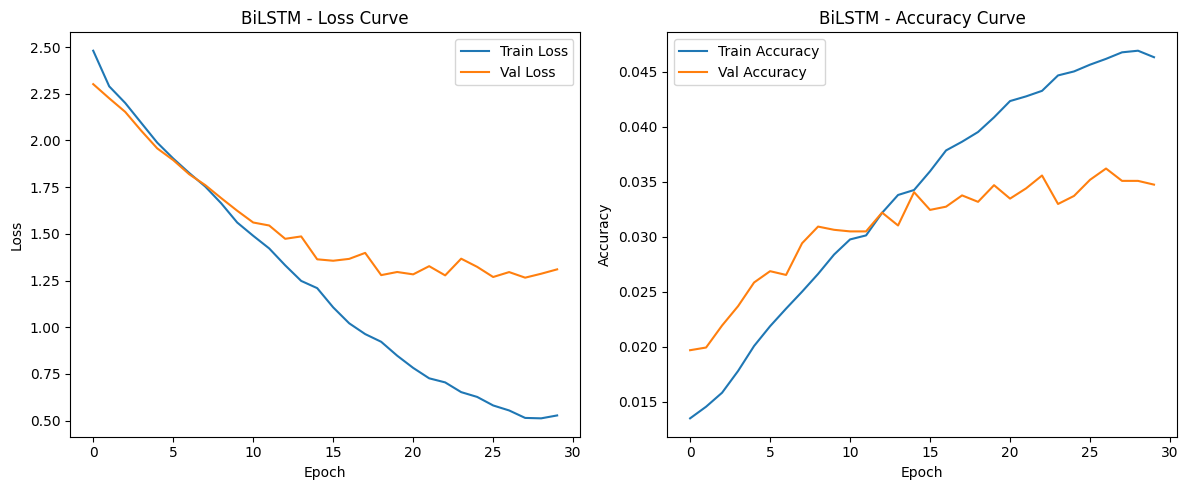

In [179]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('BiLSTM - Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['masked_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_masked_accuracy'], label='Val Accuracy')
plt.title('BiLSTM - Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig("training_plot.png")
plt.show()

## Test With Sample Data

In [181]:
# Debug model predictions
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import load_model

# Load trained model
model = load_model(
    "best_bilstm_model.keras",
    custom_objects={
        "masked_accuracy": masked_accuracy,
        "masked_sparse_categorical_crossentropy": masked_sparse_categorical_crossentropy
    }
)

# Preprocess text for prediction
def preprocess_text(text, max_len=128):
    words = text.split()
    x = [ft_model.get_word_vector(word) for word in words]
    x = tf.keras.preprocessing.sequence.pad_sequences(
        [x], maxlen=max_len, padding='post', dtype='float32'
    )[0]
    return tf.expand_dims(x, axis=0)

# Predict NER tags with debugging
def predict_ner(text):
    x = preprocess_text(text)
    y_pred = model.predict(x)
    y_pred = np.argmax(y_pred, axis=-1)[0]
    predicted_tags = [idx2tag.get(idx, 'UNKNOWN') for idx in y_pred[:len(text.split())]]
    print(f"Sentence: {text}")
    print(f"Raw predicted tags: {predicted_tags}")
    
    # Aggregate labels
    label_counts = {}
    for label in predicted_tags:
        if label != 'O' and '_' in label:
            category = label.split('_')[0]
            if category in ['FUEL', 'MACHINE', 'OTHERS', 'PART', 'PRICE', 'SERVICE']:
                label_counts[label] = label_counts.get(label, 0) + 1
    
    priority_categories = ['FUEL', 'MACHINE', 'OTHERS', 'PART', 'PRICE', 'SERVICE']
    for category in priority_categories:
        for polar in ['POSITIVE', 'NEGATIVE']:
            if f"{category}_{polar}" in label_counts:
                return {"label": f"{category}_{polar}", "sentence": text}
    
    return {"label": "No dominant label found", "sentence": text}

# Test sentences
test_sentences = [
    "Bensin hemat banget",
    "Mesin fortuner cepat panas",
    "Pelayanan yamaha kurang ramah",
    "Bensin bmw boros",
    "Mesin honda jelek banget"
]

# Run predictions
print("Testing model predictions:")
for sentence in test_sentences:
    result = predict_ner(sentence)
    print(result)

Testing model predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Sentence: Bensin hemat banget
Raw predicted tags: ['FUEL_POSITIVE', 'FUEL_POSITIVE', 'FUEL_POSITIVE']
{'label': 'FUEL_POSITIVE', 'sentence': 'Bensin hemat banget'}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Sentence: Mesin fortuner cepat panas
Raw predicted tags: ['MACHINE_POSITIVE', 'PRODUCT', 'FUEL_POSITIVE', 'FUEL_POSITIVE']
{'label': 'FUEL_POSITIVE', 'sentence': 'Mesin fortuner cepat panas'}
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
Sentence: Pelayanan yamaha kurang ramah
Raw predicted tags: ['PRICE_POSITIVE', 'PRODUCT', 'FUEL_POSITIVE', 'FUEL_POSITIVE']
{'label': 'FUEL_POSITIVE', 'sentence': 'Pelayanan yamaha kurang ramah'}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Sentence: Bensin bmw boros
Raw predicted tags: ['FUEL_POSITIVE', 'PRODUCT', 'FUEL_POSITIVE']
{'label': 'FUEL_POSITIVE', 'sentence': 'Bensin bmw boros'}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Sentence: Mesin honda jelek banget
Raw predicted tags: ['MACHINE_POSITIVE', 'PRO